## Load, filter and plot data

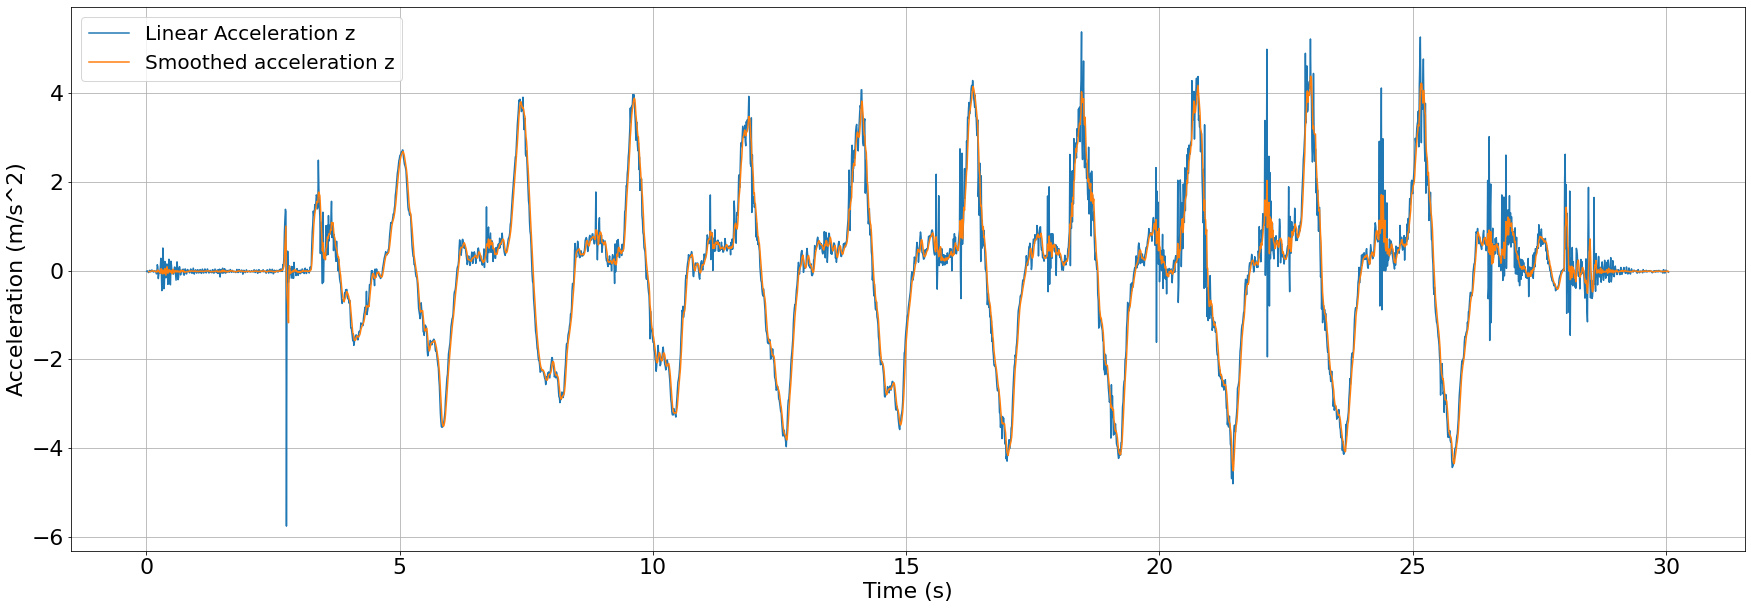

In [32]:
import pandas
import matplotlib.pyplot as plt

GRAVITY_CONSTANT = 9.80655
COUNTED_REPETITIONS = 10
MASS = 30

df = pandas.read_csv('data/Acceleration without g 2024-03-17 19-47-45/Raw Data.csv')
df['Smoothed Acceleration z (m/s^2)'] = df['Linear Acceleration z (m/s^2)'].rolling(window=5).mean()

plt.figure(figsize=(30,10))
plt.plot(df['Time (s)'], df['Linear Acceleration z (m/s^2)'], label='Linear Acceleration z')
plt.plot(df['Time (s)'], df['Smoothed Acceleration z (m/s^2)'], label='Smoothed acceleration z')
plt.xlabel('Time (s)', fontsize=22)
plt.ylabel('Acceleration (m/s^2)', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=20)
plt.grid()
plt.show()

## Trim start and end

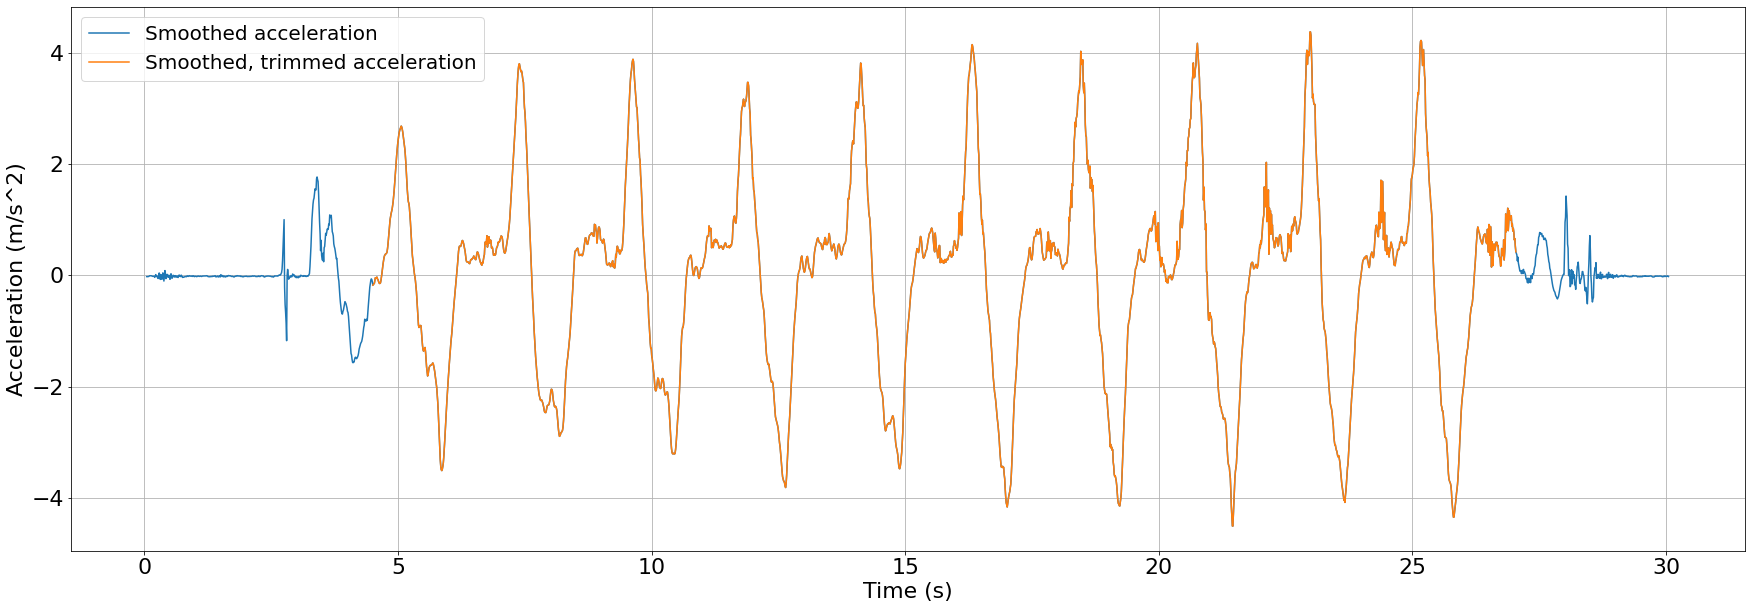

In [33]:
plt.figure(figsize=(30,10))
plt.plot(df['Time (s)'], df['Smoothed Acceleration z (m/s^2)'], label='Smoothed acceleration')

starting_time = 4.5
ending_time = df['Time (s)'].max() - 3.0
df = df[df['Time (s)'] >= starting_time]
df = df[df['Time (s)'] <= ending_time]
df = df.reset_index(drop=True)

plt.plot(df['Time (s)'], df['Smoothed Acceleration z (m/s^2)'], label='Smoothed, trimmed acceleration')
plt.xlabel('Time (s)', fontsize=22)
plt.ylabel('Acceleration (m/s^2)', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=20)
plt.grid()

## Iterate over values, find velocity and position

In [22]:
def get_velocity(acceleration: float, V0: float, delta_t: float):
  # a = (V1-V0) / t
  # V1 = a*t + V0
  return acceleration * delta_t + V0

def get_distance(delta_V: float, delta_t: float):
  # V = s/t
  # s = V*t
  return delta_V * delta_t

def get_energy_spent(mass: float, distance: float, acceleration: float):
  # A = F*s
  # F = m*a
  # A = m*a*s
  return mass * (acceleration + GRAVITY_CONSTANT) * distance

def joules_to_kcal(joules: float):
  return joules / 4184

previous_time = starting_time
previous_velocity = 0.0
total_distance = 0.0
total_energy = 0.0
velocity_vec = [[]]
distance_vec = [[]]
energy_vec = [[]]

for index, row in df.iterrows():
  timestep = row["Time (s)"] - previous_time

  velocity = get_velocity(row["Smoothed Acceleration z (m/s^2)"], previous_velocity, timestep)
  velocity_vec.append([row["Time (s)"], velocity])

  distance_step = get_distance(velocity, timestep)
  total_distance += distance_step
  distance_vec.append([row["Time (s)"], total_distance])

  energy_step = get_energy_spent(MASS, distance_step, row["Smoothed Acceleration z (m/s^2)"])
  total_energy += abs(energy_step)
  energy_vec.append([row["Time (s)"], total_energy])

  previous_velocity = velocity
  previous_time = row["Time (s)"]

## Detect peaks

Repetitions:  10


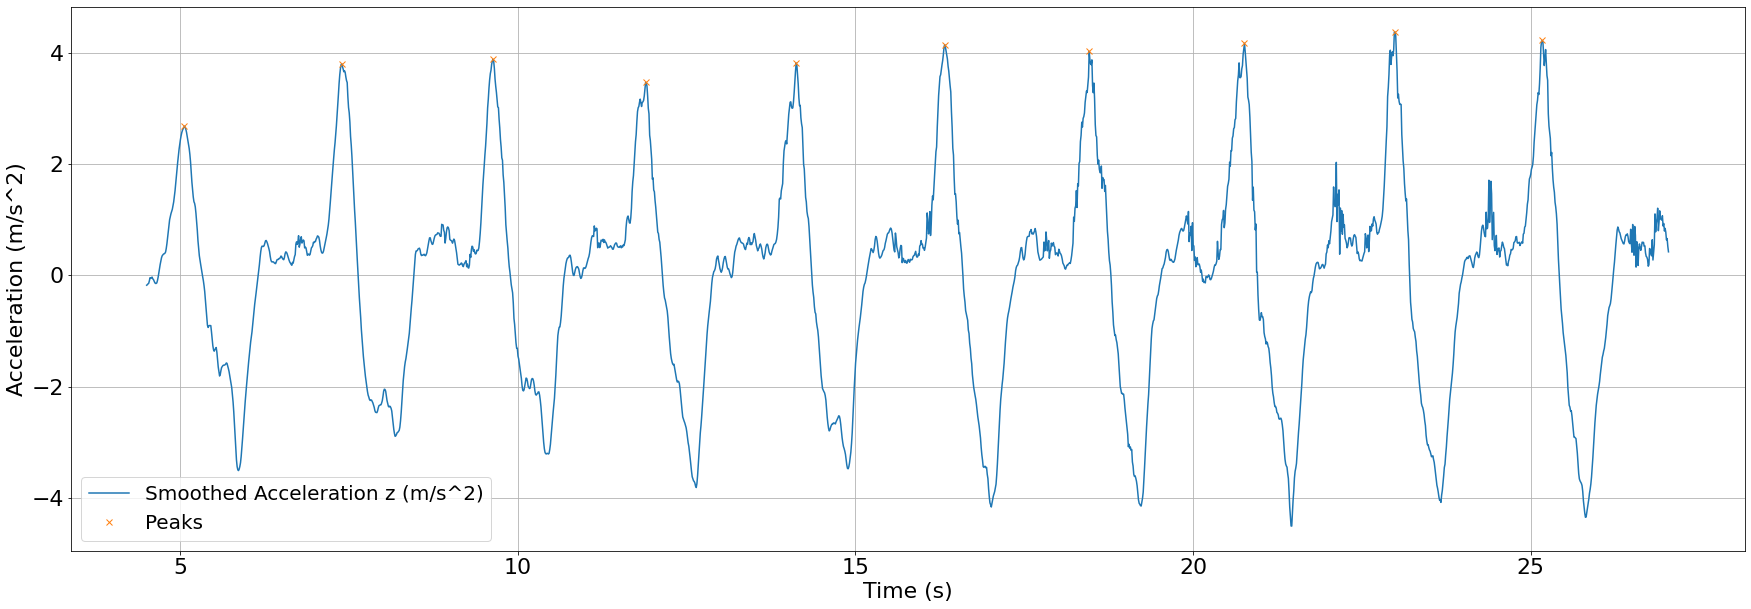

In [29]:
from scipy.signal import find_peaks

prominence_threshold = 2
distance_between_peaks = 150

peaks, _ = find_peaks(df['Smoothed Acceleration z (m/s^2)'].values, prominence=prominence_threshold, distance=distance_between_peaks)
print("Repetitions: ", len(peaks))

plt.figure(figsize=(30,10))
plt.plot(df['Time (s)'], df['Smoothed Acceleration z (m/s^2)'], label='Smoothed Acceleration z (m/s^2)')
plt.plot(df['Time (s)'][peaks], df['Smoothed Acceleration z (m/s^2)'][peaks], 'x', label='Peaks')
plt.xlabel('Time (s)', fontsize=22)
plt.ylabel('Acceleration (m/s^2)', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=20)
plt.grid()
plt.show()

## Plot velocity

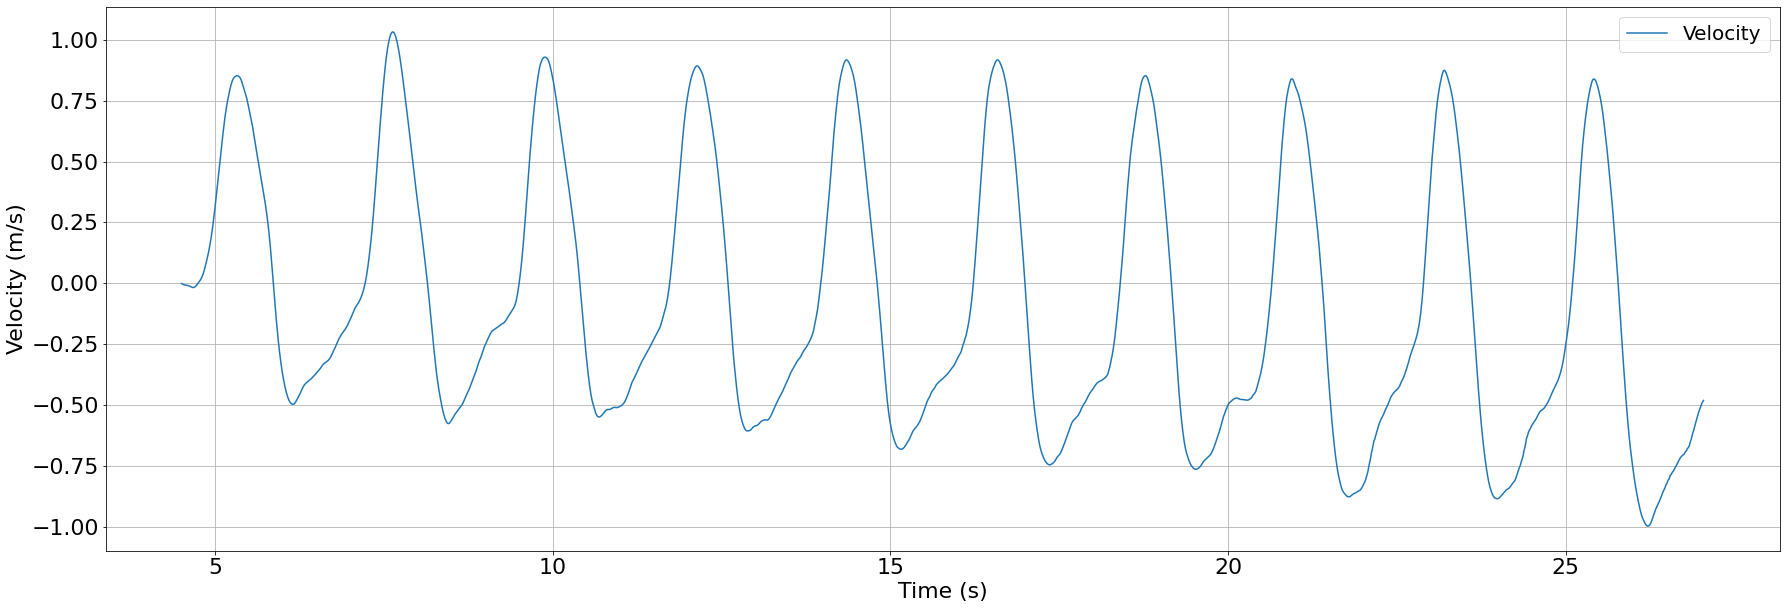

In [26]:
velocity_df = pandas.DataFrame(velocity_vec, columns=['Time (s)', 'Velocity (m/s)'])
plt.figure(figsize=(30,10))
plt.plot(velocity_df['Time (s)'], velocity_df['Velocity (m/s)'], label='Velocity')

plt.xlabel('Time (s)', fontsize=22)
plt.ylabel('Velocity (m/s)', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=20)
plt.grid()
plt.show()

## Plot displacement

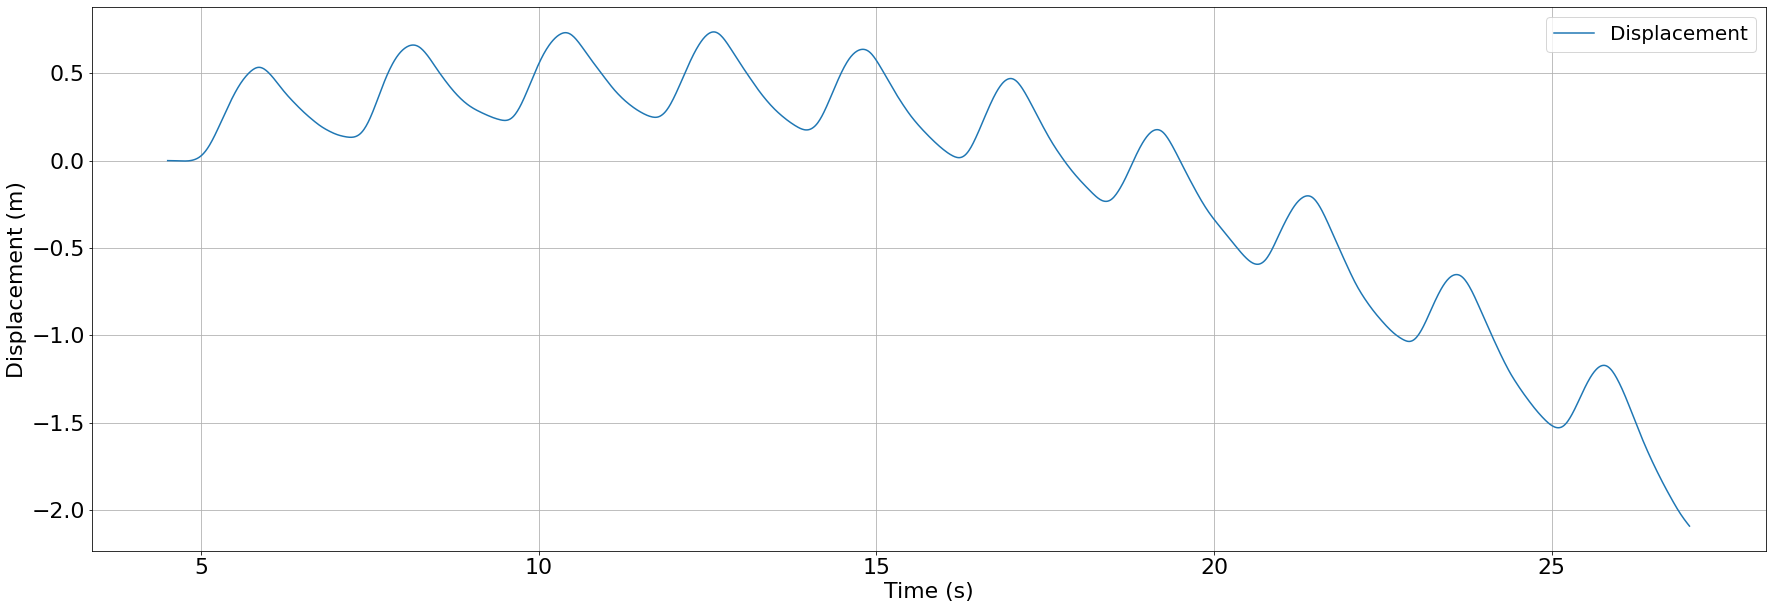

In [27]:
distance_df = pandas.DataFrame(distance_vec, columns=['Time (s)', 'Displacement (m)'])

plt.figure(figsize=(30,10))
plt.plot(distance_df['Time (s)'], distance_df['Displacement (m)'], label='Displacement')

plt.xlabel('Time (s)', fontsize=22)
plt.ylabel('Displacement (m)', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=20)
plt.grid()
plt.show()

## Separate upward motions

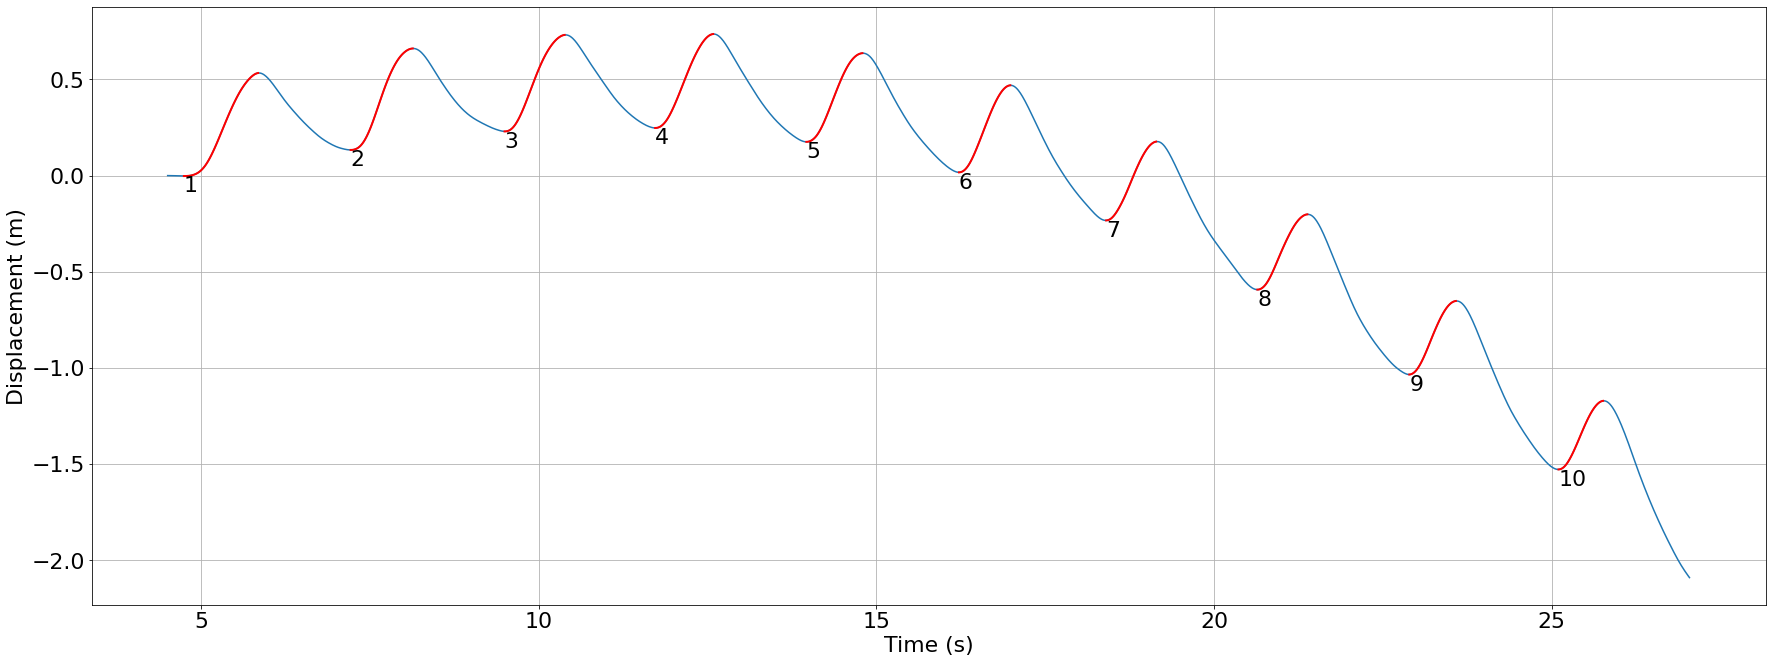

In [30]:
def get_upward_motion_indices(displacement_data):
  start_indices = []
  end_indices = []
  for i in range(1, len(displacement_data) - 1):
    if displacement_data[i-1] < displacement_data[i] and displacement_data[i] >= displacement_data[i+1]:
      end_indices.append(i)
    if displacement_data[i-1] >= displacement_data[i] and displacement_data[i] < displacement_data[i+1]:
      start_indices.append(i)
  return start_indices, end_indices

start_indices, end_indices = get_upward_motion_indices(distance_df['Displacement (m)'].values)

plt.figure(figsize=(30, 11))
plt.plot(distance_df['Time (s)'], distance_df['Displacement (m)'], label='Displacement')

for i in range(len(start_indices)):
  label = f"{i+1}"
  plt.plot(distance_df['Time (s)'][start_indices[i]:end_indices[i]], distance_df['Displacement (m)'][start_indices[i]:end_indices[i]], color="red", linewidth=2)
  plt.text(distance_df['Time (s)'][start_indices[i]], distance_df['Displacement (m)'][start_indices[i]], label, fontsize=22, verticalalignment='top', color='black')

plt.xlabel('Time (s)', fontsize=22)
plt.ylabel('Displacement (m)', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.grid()
plt.show()

## Find energy spent

In [216]:
energy_rep_vec = []
for i in range(len(start_indices)):
  energy_rep_vec.append(energy_vec[end_indices[i]][1] - energy_vec[start_indices[i]][1])

print(energy_rep_vec)
total_energy_reps = round(sum(energy_rep_vec), 3)
print("Total energy is: ", total_energy_reps, "Joules")
print("Total energy is: ", joules_to_kcal(total_energy_reps), "Kcal")

displacement_change_per_rep = []
for i in range(len(start_indices)):
  displacement_change_per_rep.append(round(distance_df['Displacement (m)'][end_indices[i]] - distance_df['Displacement (m)'][start_indices[i]], 3))

print("Rep distance changes: ", displacement_change_per_rep)

rep_time = []
for i in range(len(start_indices)):
  rep_time.append(round(distance_df['Time (s)'][end_indices[i]] - distance_df['Time (s)'][start_indices[i]], 3))

print("Rep times: ", rep_time)

[158.1399740878179, 156.0059545650435, 148.336095575174, 144.38257921898685, 136.33666661102552, 133.97870838200083, 121.34942324219696, 115.84857230819762, 113.30415463151348, 105.75171875866272]
Total energy is:  1333.434 Joules
Total energy is:  0.3186983747609943 Kcal
Rep distance changes:  [0.536, 0.528, 0.502, 0.488, 0.461, 0.453, 0.41, 0.391, 0.382, 0.357]
Rep times:  [1.11, 0.93, 0.9, 0.87, 0.84, 0.77, 0.75, 0.75, 0.7, 0.67]


## Find maximum momentary force

In [217]:
max_acceleration = df['Smoothed Acceleration z (m/s^2)'].max()

max_force = MASS * (max_acceleration + GRAVITY_CONSTANT)
max_force

425.551204692

## Find energy baseline

In [219]:
rep_distance = 0.5

potential_energy_delta = MASS * GRAVITY_CONSTANT * rep_distance
total_energy_baseline = potential_energy_delta * COUNTED_REPETITIONS

print("Potential energy difference per rep (J): ", potential_energy_delta)
print("Potential energy difference per rep (kcal): ", joules_to_kcal(potential_energy_delta))
print("Potential energy difference total (J): ", total_energy_baseline)
print("Potential energy difference total (kcal): ", joules_to_kcal(total_energy_baseline))

Potential energy difference per rep (J):  147.09825
Potential energy difference per rep (kcal):  0.03515732552581262
Potential energy difference total (J):  1470.9825
Potential energy difference total (kcal):  0.3515732552581262
